# Tabular Montecarlo First Visit and Every Visit Implementation

In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

def create_env():
    #return gym.make('FrozenLake-v1', is_slippery=False)  # or True, depending on your use case
    return gym.make('FrozenLake-v1', is_slippery=False)

def initialize_q_table(env):
    number_of_states = env.observation_space.n
    number_of_actions = env.action_space.n
    return np.zeros((number_of_states, number_of_actions))

# Decay function for epsilon
def decay_function(episode, total_train_episodes, min_epsilon, max_epsilon, current_epsilon, decay_type):
    if decay_type == 'linear':
        print("linear")
        tmp = current_epsilon = current_epsilon - (current_epsilon / total_train_episodes)
        return max(min_epsilon,tmp)
    elif decay_type == 'log':
        print("log")
        return max(min_epsilon, min(1.0, 1.0 - np.log10((episode + 1) / (total_train_episodes * 0.1))))
    elif decay_type == 'slow':
        print("slow")
        return 0.99 * current_epsilon

def choose_action(q_table, state, epsilon, env):
    if np.random.random() <= epsilon:
        return env.action_space.sample()  # Exploration
    else:
        return np.argmax(q_table[state])  # Exploitation

def Generate_episode(epsilon, q_table, env, max_env_steps):
    state = env.reset()
    total_reward = 0
    done = False
    trajectory = []
    
    for step in range(max_env_steps):
        if isinstance(state, tuple):
            state = state[0]

        action = choose_action(q_table, state, epsilon, env)
        new_state, reward, done, info, _ = env.step(action)
        trajectory.append([state, action, reward])
        state = new_state
        total_reward += reward
        if done:
            break
    
    return trajectory, total_reward

# Monte Carlo algorithm first visit version
def Monte_Carlo_First_Visit(env, total_train_episodes, gamma, max_epsilon, min_epsilon, current_epsilon, decay_type):
    q_table = initialize_q_table(env)
    visits_counter = np.zeros_like(q_table)
    rewards = []
    history = np.zeros((total_train_episodes, *q_table.shape))
    max_env_steps = env.spec.max_episode_steps
    epsilons = np.zeros(total_train_episodes)

    for episode in range(total_train_episodes):
        epsilon = decay_function(episode, total_train_episodes, min_epsilon, current_epsilon, decay_type)
        trajectory, total_reward = Generate_episode(epsilon, q_table, env, max_env_steps)
        G = 0
        gamma = 0.99
        first_visit_check = set()
        for t in reversed(range(len(trajectory))):
            state, action, reward = trajectory[t]
            G = gamma * G + reward
            print(f"State: {state}, Action: {action}, Reward: {G}")
            
            if isinstance(state, dict):
                state = state.get('state_key', 0)  
            if isinstance(state, tuple):
                    state = state[0]
            #if visits_counter[state,action]==0:
            if (state,action) not in first_visit_check:
                first_visit_check.add((state,action))
                visits_counter[state, action] += 1
                q_table[state, action] += (G - q_table[state, action]) / visits_counter[state, action]

        history[episode] = q_table
        epsilons[episode] = epsilon
        
        if episode % 100 == 0:
            rewards.append(total_reward)

    print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    return q_table,history, epsilons

# Monte Carlo algorithm - Every Visit Version
def Monte_Carlo_Every_Visit(env, total_train_episodes, gamma, max_epsilon, min_epsilon, current_epsilon, decay_type):
    q_table = initialize_q_table(env)
    visits_counter = np.zeros_like(q_table)
    
    history = np.zeros((total_train_episodes, *q_table.shape))
    epsilons = np.zeros(total_train_episodes)
    
    max_env_steps = env.spec.max_episode_steps
    
    for episode in range(total_train_episodes):
        epsilon = decay_function(episode, total_train_episodes, min_epsilon, current_epsilon, decay_type)
        trajectory, total_reward = Generate_episode(epsilon, q_table, env, max_env_steps)
        G = 0
       
        
        for t in reversed(range(len(trajectory))):
            state, action, reward = trajectory[t]
            G = gamma * G + reward
            
            if isinstance(state, tuple):
                state = state[0]  # Adjust for your state representation

            # every-visit MC    
            visits_counter[state, action] += 1
            q_table[state, action] += (G - q_table[state, action]) / visits_counter[state, action]
        
        history[episode] = q_table
        epsilons[episode] = epsilon
            
    print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    return q_table, history, epsilons





    


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Main code
if __name__ == "__main__":
    n_times = 1 #10 is slippery true, 5 otherwise
    total_train_episodes = 1000 #50000 if is slippery true
    gamma = 0.99
    max_epsilon = 1.0
    min_epsilon = 0.01
    current_epsilon = 1.0

    env = create_env()

    for number in range(n_times):
        #print(f"\n ********** Training number {number}")
        q_table1, history1, epsilons1 = Monte_Carlo_First_Visit(env, 800, gamma, max_epsilon, min_epsilon, current_epsilon, "log")
        q_table2, history2, epsilons2 = Monte_Carlo_First_Visit(env, 5000, gamma, max_epsilon, min_epsilon, current_epsilon, "slow")
        q_table3, history3, epsilons3 = Monte_Carlo_First_Visit(env, 10000, gamma, max_epsilon, min_epsilon, current_epsilon, "linear")
        
    np.save('ON/models/FV_MC_tables_log.npy', history1)
    np.save('ON/models/FV_MC_Q_log.npy', q_table1)
    np.save('ON/models/FV_MC_epsilons_log.npy', epsilons1)

 
    np.save('ON/models/FV_MC_tables_slow.npy', history2)
    np.save('ON/models/FV_MC_Q_slow.npy', q_table2)
    np.save('ON/models/FV_MC_epsilons_slow.npy', epsilons2)

        
    np.save('ON/models/FV_MC_tables_linear.npy', history3)
    np.save('ON/models/FV_MC_Q_linear.npy', q_table3)
    np.save('ON/models/FV_MC_epsilons_linear.npy', epsilons3)




    for number in range(n_times):
        #print(f"\n ********** Training number {number}")
        q_table1, history1, epsilons1 = Monte_Carlo_Every_Visit(env, 800, gamma, max_epsilon, min_epsilon, current_epsilon, "log")
        q_table2, history2, epsilons2 = Monte_Carlo_Every_Visit(env, 1000, gamma, max_epsilon, min_epsilon, current_epsilon, "slow")
        q_table3, history3, epsilons3 = Monte_Carlo_Every_Visit(env, 5000, gamma, max_epsilon, min_epsilon, current_epsilon, "linear")
        
    np.save('ON/models/EV_MC_tables_log.npy', history1)
    np.save('ON/models/EV_MC_Q_log.npy', q_table1)
    np.save('ON/models/EV_MC_epsilons_log.npy', epsilons1)

 
    np.save('ON/models/EV_MC_tables_slow.npy', history2)
    np.save('ON/models/EV_MC_Q_slow.npy', q_table2)
    np.save('ON/models/EV_MC_epsilons_slow.npy', epsilons2)

        
    np.save('ON/models/EV_MC_tables_linear.npy', history3)
    np.save('ON/models/EV_MC_Q_linear.npy', q_table3)
    np.save('ON/models/EV_MC_epsilons_linear.npy', epsilons3)

  


# Policy Plot

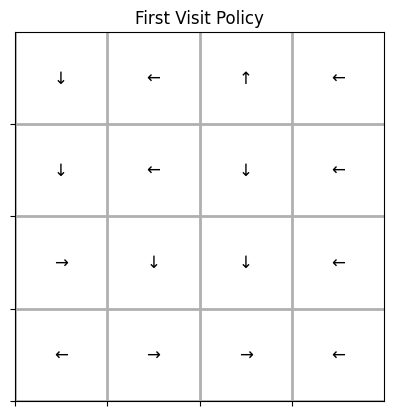

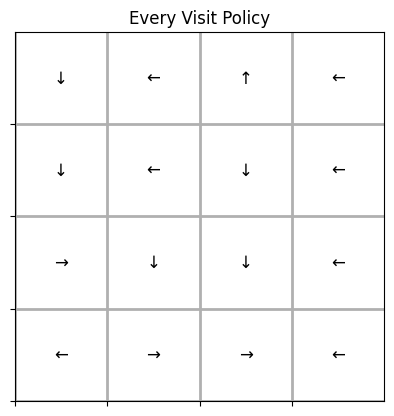

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_policy(q_table, grid_size=(4, 4), title='Policy', save_path=None):
   
    # Define direction labels
    direction_labels = {
        0: '←',  # left
        1: '↓',  # down
        2: '→',  # right
        3: '↑'   # up
    }

   
    policy = np.argmax(q_table, axis=1).reshape(grid_size)
    
    # Set up the grid
    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(grid_size[1]))
    ax.set_yticks(np.arange(grid_size[0]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Create grid
    ax.grid(which='both', linestyle='-', linewidth=2)
    
    # Plot direction labels
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            action = policy[i, j]
            direction = direction_labels[action]
            ax.text(j + 0.5, grid_size[0] - i - 0.5, direction, 
                    ha='center', va='center', fontsize=12, color='black')

    # Set the aspect of the plot to equal
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.set_xlim(0, grid_size[1])
    ax.set_ylim(0, grid_size[0])
    plt.savefig(save_path)
    plt.show()

# Usage example:
if __name__ == "__main__":
    # Assuming you have already saved your Q-tables as 'MC_tables.npy'
    FV_q_table = np.load('ON/models/FV_MC_Q.npy', allow_pickle=True)
    EV_q_table = np.load('ON/models/FV_MC_Q.npy', allow_pickle=True)
    
    plot_policy(FV_q_table, title='First Visit Policy', save_path='ON/imgs/FV_policy.png')
    plot_policy(EV_q_table, title='Every Visit Policy', save_path='ON/imgs/EV_policy.png')
